In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import functools

In [2]:
image_path  = "../images/license17.jpg"

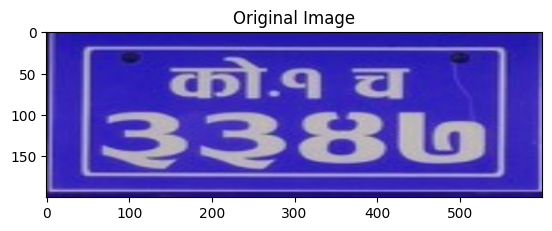

In [3]:
image = cv2.imread(image_path)
image = cv2.resize(image, (600,200))
plt.imshow(image)
plt.title('Original Image')
original_image = image.copy()
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
# image to segment will be in final_original_image below

Text(0.5, 1.0, 'Original Image RGB')

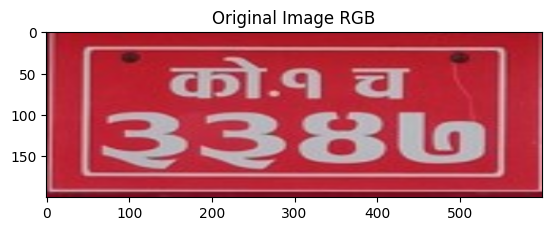

In [4]:
plt.imshow(original_image)
plt.title('Original Image RGB')

Text(0.5, 1.0, 'HSV Image')

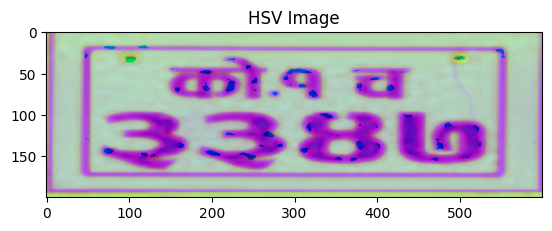

In [5]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.imshow(hsv_image)
plt.title('HSV Image')

Text(0.5, 1.0, 'Red Mask')

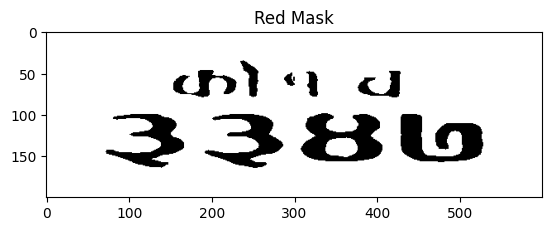

In [6]:
lower_red = np.array([0, 50, 50])
upper_red = np.array([10, 255, 255])
mask1 = cv2.inRange(hsv_image, lower_red, upper_red)

lower_red = np.array([170, 50, 50])
upper_red = np.array([180, 255, 255])
mask2 = cv2.inRange(hsv_image, lower_red, upper_red)

red_mask = cv2.bitwise_or(mask1, mask2)

plt.imshow(red_mask, cmap="gray")
plt.title('Red Mask')


Text(0.5, 1.0, 'Masked Image')

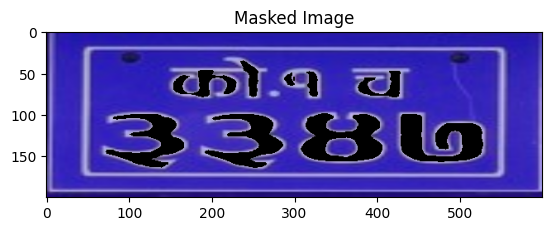

In [7]:

masked_image = cv2.bitwise_and(image, image, mask=red_mask)
plt.imshow(masked_image)
plt.title('Masked Image')

In [8]:
def perspective_transform(image, pts):
    # Get the maximum width and height
    max_width = max(np.linalg.norm(pts[0] - pts[1]), np.linalg.norm(pts[2] - pts[3]))
    max_height = max(np.linalg.norm(pts[0] - pts[3]), np.linalg.norm(pts[1] - pts[2]))

    # Set destination points
    dst_pts = np.array([[0, 0], [max_width - 1, 0], [max_width - 1, max_height - 1], [0, max_height - 1]], dtype='float32')

    # Calculate perspective transform matrix
    matrix = cv2.getPerspectiveTransform(pts, dst_pts)

    # Apply perspective transform
    result = cv2.warpPerspective(image, matrix, (int(max_width), int(max_height)))

    return result


In [9]:
contours, hierarchy= cv2.findContours(red_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Sort contours by area and get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Approximate a minimum rectangle around the largest contour
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    # Convert box points to float32
    box = box.astype(np.float32)

    # Perform perspective transform
    transformed_image = perspective_transform(image, box)

if transformed_image.shape[0] > transformed_image.shape[1]:
    transformed_image = cv2.rotate(transformed_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
resized_image = cv2.resize(transformed_image, (600, 200))



Text(0.5, 1.0, 'Transformed Image')

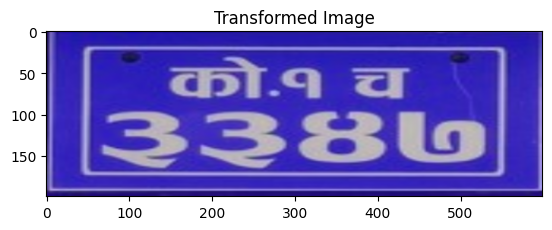

In [10]:
plt.imshow(transformed_image)
plt.title('Transformed Image')

Text(0.5, 1.0, 'Transformed and resized image')

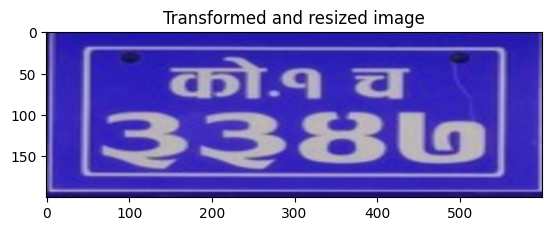

In [11]:
plt.imshow(resized_image)
plt.title("Transformed and resized image")

Text(0.5, 1.0, 'Final image')

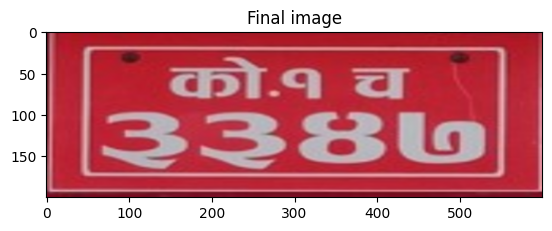

In [12]:
# saving the resized image
resized_image.shape
final_original_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
plt.imshow(final_original_image)
plt.title("Final image")

Text(0.5, 1.0, 'Gray Image')

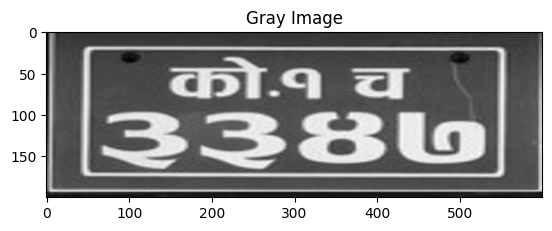

In [13]:
image_process = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_process, cmap="gray")
plt.title('Gray Image')

Text(0.5, 1.0, 'After blur')

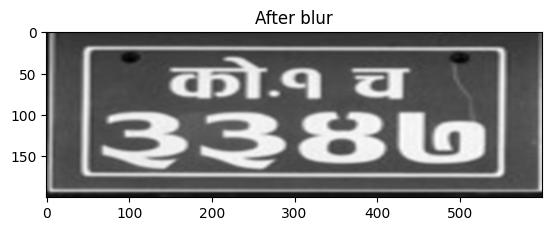

In [14]:
kernel = np.ones((5,5),dtype=np.uint8)
blurred_image = cv2.GaussianBlur(image_process, (5,5), 0)
plt.imshow(blurred_image, cmap="gray")
plt.title("After blur")

In [15]:
blurred_image.shape

(200, 600)

Text(0.5, 1.0, 'Threshold image')

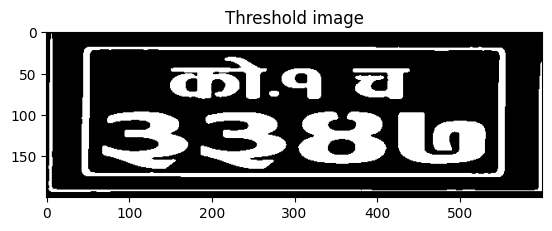

In [16]:
ret, thresh = cv2.threshold(blurred_image,125,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')
plt.title("Threshold image")

Text(0.5, 1.0, 'Image with Border')

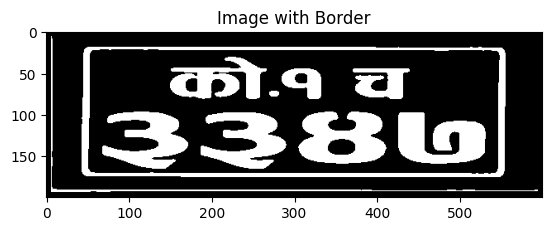

In [17]:
border_size = 10
border_color = (0, 0, 0)  # black color

# Add border to the image
cv2.rectangle(thresh, (0, 0), (thresh.shape[1], thresh.shape[0]), border_color, border_size)

plt.imshow(thresh, cmap='gray')
plt.title('Image with Border')



In [18]:
_, labels = cv2.connectedComponents(thresh)
mask = np.zeros(thresh.shape, dtype="uint8")

In [19]:
total_pixels = image.shape[0] * image.shape[1]
lower = 100
upper = total_pixels * 0.2

In [20]:
# Loop over the unique components
for (i, label) in enumerate(np.unique(labels)):
    # label 0 vaneko background ho
    if label == 0:
        continue

    # otherwise construct the label mask to display only connected component
    # for the current label
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)

    # Get the bounding box of the connected component
    (y, x) = np.where(labels == label)
    (topY, topX) = (np.min(y), np.min(x))
    (bottomY, bottomX) = (np.max(y), np.max(x))
    width = bottomX - topX
    height = bottomY - topY

    # filtering the bounding box
    if width > 250 or height > 150:
        continue

    # more filtering
    if width > 20 and height > 15:
        if numPixels > lower and numPixels < upper:
            mask = cv2.add(mask, labelMask)

Text(0.5, 1.0, 'After cleaning image')

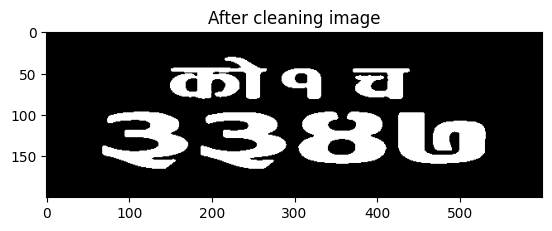

In [21]:
plt.imshow(mask,cmap='gray')
plt.title("After cleaning image")

In [22]:
# contours, hierarchy= cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# boundingBoxes = [cv2.boundingRect(c) for c in contours]
contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 1000]
print(boundingBoxes)

for c in contours:
    print(cv2.contourArea(c))


[(426, 98, 106, 62), (187, 98, 104, 68), (305, 97, 107, 63), (68, 97, 104, 69), (371, 45, 69, 37), (285, 45, 48, 37), (150, 31, 117, 51)]
4255.0
3481.5
4851.0
3458.5
1451.0
1159.0
3059.0


In [23]:
def compare(rect1, rect2):
    if abs(rect1[1] - rect2[1]) > 30:
        return rect1[1] - rect2[1]
    else:
        return rect1[0] - rect2[0]
boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare) )
print(boundingBoxes)

[(150, 31, 117, 51), (285, 45, 48, 37), (371, 45, 69, 37), (68, 97, 104, 69), (187, 98, 104, 68), (305, 97, 107, 63), (426, 98, 106, 62)]


In [24]:
boundingBoxes = [bbox for bbox in boundingBoxes if bbox[2] * bbox[3] > 1300 and bbox[2] / bbox[3] <= 4 and bbox[3] / bbox[2] <= 4]
print(boundingBoxes)

[(150, 31, 117, 51), (285, 45, 48, 37), (371, 45, 69, 37), (68, 97, 104, 69), (187, 98, 104, 68), (305, 97, 107, 63), (426, 98, 106, 62)]


In [25]:
for i, bbox in enumerate(boundingBoxes):
    x, y, w, h = bbox
    if x > 5 and y > 10:
            padding = 10
    else:
            padding = 0
    padding = 0
    cropped_image = final_original_image[y-padding:y+h+padding, x-padding:x+w+padding]
    cropped_resized = cv2.resize(cropped_image, (64,64))
    cv2.imwrite(f'../ANPR/results/cropped_image_{i}.png', cropped_resized)

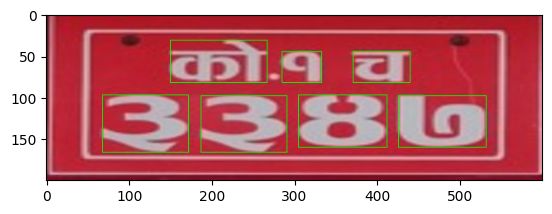

In [26]:
for bbox in boundingBoxes:
    x, y, w, h = bbox
    cv2.rectangle(final_original_image, (x, y), (x+w, y+h), (0, 255, 0), 1)
plt.imshow(final_original_image)